# Extreme-Value Testing: Testing Model Behavior at Boundaries

This notebook demonstrates **extreme-value testing** - a validation technique that tests how models behave at the boundaries of what is possible.

Understanding extreme-value testing is essential because:
- **Models often break at extremes** - they work fine for normal conditions but fail at boundaries
- **Extreme conditions do happen** - even if rare, you need to be prepared
- **Extreme-value testing finds limits** - helps you know when to trust the model and when to use alternatives
- **Preparation prevents crises** - you're ready when extreme conditions occur


## Key Concepts

**Extreme-Value Testing** tests model behavior at boundaries:
- You push inputs to their minimum and maximum possible values
- You observe how the model behaves under extreme conditions
- You identify where the model breaks or produces invalid results
- You document the model's limits

**Why It Matters**:
- **Models have limits** - they work well for normal conditions but may break at extremes
- **Extreme conditions happen** - even if rare, you need to be prepared
- **Testing extremes finds problems early** - before they cause damage during crises
- **Knowing limits helps you decide** - when to trust the model and when to use alternatives

**Critical insight**: Extreme-value testing is like stress-testing - you push the model to find its breaking points so you know when it's safe to use.


## Scenario: Delivery Routing with Capacity Limits

You manage a delivery service that optimizes routes for a fleet of trucks. The model recommends routes based on delivery volumes and truck capacity.

**The Challenge**: You need to know the model's limits. What happens when:
- Delivery volume is zero (minimum)?
- Delivery volume is maximum possible (all trucks fully loaded)?
- Truck capacity is reduced to minimum?
- Delivery times are extremely long?

**The Question**: At what extremes does the model break? What are its limits?

**Decision variables**: Route assignments, truck allocations

**Extremes to test**: Minimum/maximum demand, minimum/maximum capacity, extreme time constraints


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [21]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, PULP_CBC_CMD


## Step 3: Set Up Base Model

First, let's create a simplified delivery routing model:


In [23]:
def solve_delivery_model(total_deliveries, truck_capacity, num_trucks=5, cost_per_truck=100):
    """
    Simplified delivery routing model.
    Objective: Minimize number of trucks used (cost)
    Constraint: All deliveries must be made
    Returns: (trucks_used, total_cost, status)
    """
    # Create model
    model = LpProblem("Delivery_Routing", LpMinimize)
    
    # Decision variables: Whether to use each truck
    trucks = [LpVariable(f"truck_{i}", cat='Binary') for i in range(num_trucks)]
    
    # Objective: Minimize number of trucks used
    model += lpSum(trucks), "Minimize_Trucks"
    
    # Constraint: All deliveries must be made
    # Each truck can handle up to truck_capacity deliveries
    model += lpSum([truck_capacity * trucks[i] for i in range(num_trucks)]) >= total_deliveries, "Meet_Deliveries"
    
    # Solve
    status = model.solve(PULP_CBC_CMD(msg=0))
    
    # Get results
    trucks_used = sum([value(trucks[i]) for i in range(num_trucks)])
    total_cost = trucks_used * cost_per_truck
    
    # Check if solution is valid
    # Valid if: trucks used is within bounds, and capacity meets deliveries
    # Special case: 0 trucks is valid when there are 0 deliveries
    if total_deliveries == 0:
        is_valid = (trucks_used == 0)
    else:
        is_valid = (trucks_used > 0 and trucks_used <= num_trucks and 
                    trucks_used * truck_capacity >= total_deliveries)
    
    return (trucks_used, total_cost, status, is_valid)

# Base case (normal conditions)
base_deliveries = 20
base_capacity = 5
base_trucks_used, base_cost, base_status, base_valid = solve_delivery_model(base_deliveries, base_capacity)

print("BASE MODEL (Normal Conditions):")
print("=" * 80)
print(f"  Total Deliveries: {base_deliveries}")
print(f"  Truck Capacity: {base_capacity} deliveries per truck")
print(f"  Trucks Available: 5")
print(f"  Recommendation: Use {base_trucks_used:.0f} trucks")
print(f"  Total Cost: ${base_cost:,.0f}")
print(f"  Status: {'Valid' if base_valid else 'Invalid'}")


BASE MODEL (Normal Conditions):
  Total Deliveries: 20
  Truck Capacity: 5 deliveries per truck
  Trucks Available: 5
  Recommendation: Use 4 trucks
  Total Cost: $400
  Status: Valid


## Step 4: Test Extreme Values - Minimum Deliveries

Let's test what happens when delivery volume is at its minimum (zero):


In [24]:
# Test minimum deliveries (zero)
extreme_tests = []

# Test 1: Zero deliveries (minimum)
min_deliveries = 0
trucks_min, cost_min, status_min, valid_min = solve_delivery_model(min_deliveries, base_capacity)
extreme_tests.append({
    'Test': 'Minimum: Zero Deliveries',
    'Deliveries': min_deliveries,
    'Truck Capacity': base_capacity,
    'Trucks Used': trucks_min,
    'Total Cost': cost_min,
    'Valid': valid_min,
    'Status': 'Valid' if valid_min else 'Invalid - Model Issue'
})

print("EXTREME TEST 1: Minimum Deliveries (Zero)")
print("=" * 80)
print(f"  Deliveries: {min_deliveries}")
print(f"  Recommendation: Use {trucks_min:.0f} trucks")
print(f"  Total Cost: ${cost_min:,.0f}")
print(f"  Status: {'✓ Valid' if valid_min else '✗ Invalid - Model issue detected'}")
if trucks_min > 0:
    print(f"  ⚠️  ISSUE: Model recommends using trucks when there are no deliveries!")
elif not valid_min:
    print(f"  ⚠️  ISSUE: Model validation failed!")


EXTREME TEST 1: Minimum Deliveries (Zero)
  Deliveries: 0
  Recommendation: Use 0 trucks
  Total Cost: $0
  Status: ✓ Valid


## Step 5: Test Extreme Values - Maximum Deliveries

Now let's test what happens when delivery volume is at its maximum:


In [25]:
# Test maximum deliveries
max_deliveries = 25  # Maximum capacity of all 5 trucks (5 trucks * 5 capacity = 25)
trucks_max, cost_max, status_max, valid_max = solve_delivery_model(max_deliveries, base_capacity)

extreme_tests.append({
    'Test': 'Maximum: All Trucks Full',
    'Deliveries': max_deliveries,
    'Truck Capacity': base_capacity,
    'Trucks Used': trucks_max,
    'Total Cost': cost_max,
    'Valid': valid_max,
    'Status': 'Valid' if valid_max else 'Invalid - Exceeds Capacity'
})

print("EXTREME TEST 2: Maximum Deliveries (All Trucks Full)")
print("=" * 80)
print(f"  Deliveries: {max_deliveries} (maximum capacity)")
print(f"  Recommendation: Use {trucks_max:.0f} trucks")
print(f"  Total Cost: ${cost_max:,.0f}")
print(f"  Status: {'✓ Valid' if valid_max else '✗ Invalid'}")
if trucks_max == 5:
    print(f"  ✓ Model correctly uses all available trucks")
else:
    print(f"  ⚠️  Model may not be handling maximum capacity correctly")

# Test beyond maximum (should fail)
beyond_max = 30  # More than maximum capacity
trucks_beyond, cost_beyond, status_beyond, valid_beyond = solve_delivery_model(beyond_max, base_capacity)

extreme_tests.append({
    'Test': 'Beyond Maximum: Exceeds Capacity',
    'Deliveries': beyond_max,
    'Truck Capacity': base_capacity,
    'Trucks Used': trucks_beyond,
    'Total Cost': cost_beyond,
    'Valid': valid_beyond,
    'Status': 'Invalid - Exceeds Capacity' if not valid_beyond else 'Valid (Unexpected)'
})

print(f"\nEXTREME TEST 3: Beyond Maximum (Exceeds Capacity)")
print("=" * 80)
print(f"  Deliveries: {beyond_max} (exceeds maximum capacity of {5 * base_capacity})")
print(f"  Recommendation: Use {trucks_beyond:.0f} trucks")
print(f"  Status: {'✗ Invalid - Model cannot handle this' if not valid_beyond else '⚠️  Unexpected - Model should fail here'}")
if valid_beyond:
    print(f"  ⚠️  ISSUE: Model claims to solve impossible problem!")


EXTREME TEST 2: Maximum Deliveries (All Trucks Full)
  Deliveries: 25 (maximum capacity)
  Recommendation: Use 5 trucks
  Total Cost: $500
  Status: ✓ Valid
  ✓ Model correctly uses all available trucks

EXTREME TEST 3: Beyond Maximum (Exceeds Capacity)
  Deliveries: 30 (exceeds maximum capacity of 25)
  Recommendation: Use 6 trucks
  Status: ✗ Invalid - Model cannot handle this


## Step 6: Test Extreme Values - Minimum Capacity

Let's test what happens when truck capacity is extremely low:


In [26]:
# Test minimum capacity
min_capacity = 1  # Minimum capacity (1 delivery per truck)
# Need enough trucks available for extreme testing (20 deliveries / 1 capacity = 20 trucks needed)
trucks_min_cap, cost_min_cap, status_min_cap, valid_min_cap = solve_delivery_model(base_deliveries, min_capacity, num_trucks=25)

extreme_tests.append({
    'Test': 'Minimum Capacity: 1 Delivery per Truck',
    'Deliveries': base_deliveries,
    'Truck Capacity': min_capacity,
    'Trucks Used': trucks_min_cap,
    'Total Cost': cost_min_cap,
    'Valid': valid_min_cap,
    'Status': 'Valid' if valid_min_cap else 'Invalid'
})

print("EXTREME TEST 4: Minimum Truck Capacity")
print("=" * 80)
print(f"  Deliveries: {base_deliveries}")
print(f"  Truck Capacity: {min_capacity} delivery per truck (minimum)")
print(f"  Recommendation: Use {trucks_min_cap:.0f} trucks")
print(f"  Total Cost: ${cost_min_cap:,.0f}")
print(f"  Status: {'✓ Valid' if valid_min_cap else '✗ Invalid'}")
if trucks_min_cap == base_deliveries:
    print(f"  ✓ Model correctly handles minimum capacity")
else:
    print(f"  ⚠️  Model may not be handling minimum capacity correctly")


EXTREME TEST 4: Minimum Truck Capacity
  Deliveries: 20
  Truck Capacity: 1 delivery per truck (minimum)
  Recommendation: Use 20 trucks
  Total Cost: $2,000
  Status: ✓ Valid
  ✓ Model correctly handles minimum capacity


## Step 7: Visualize Extreme Value Test Results

Let's visualize the model's behavior across different extreme values:


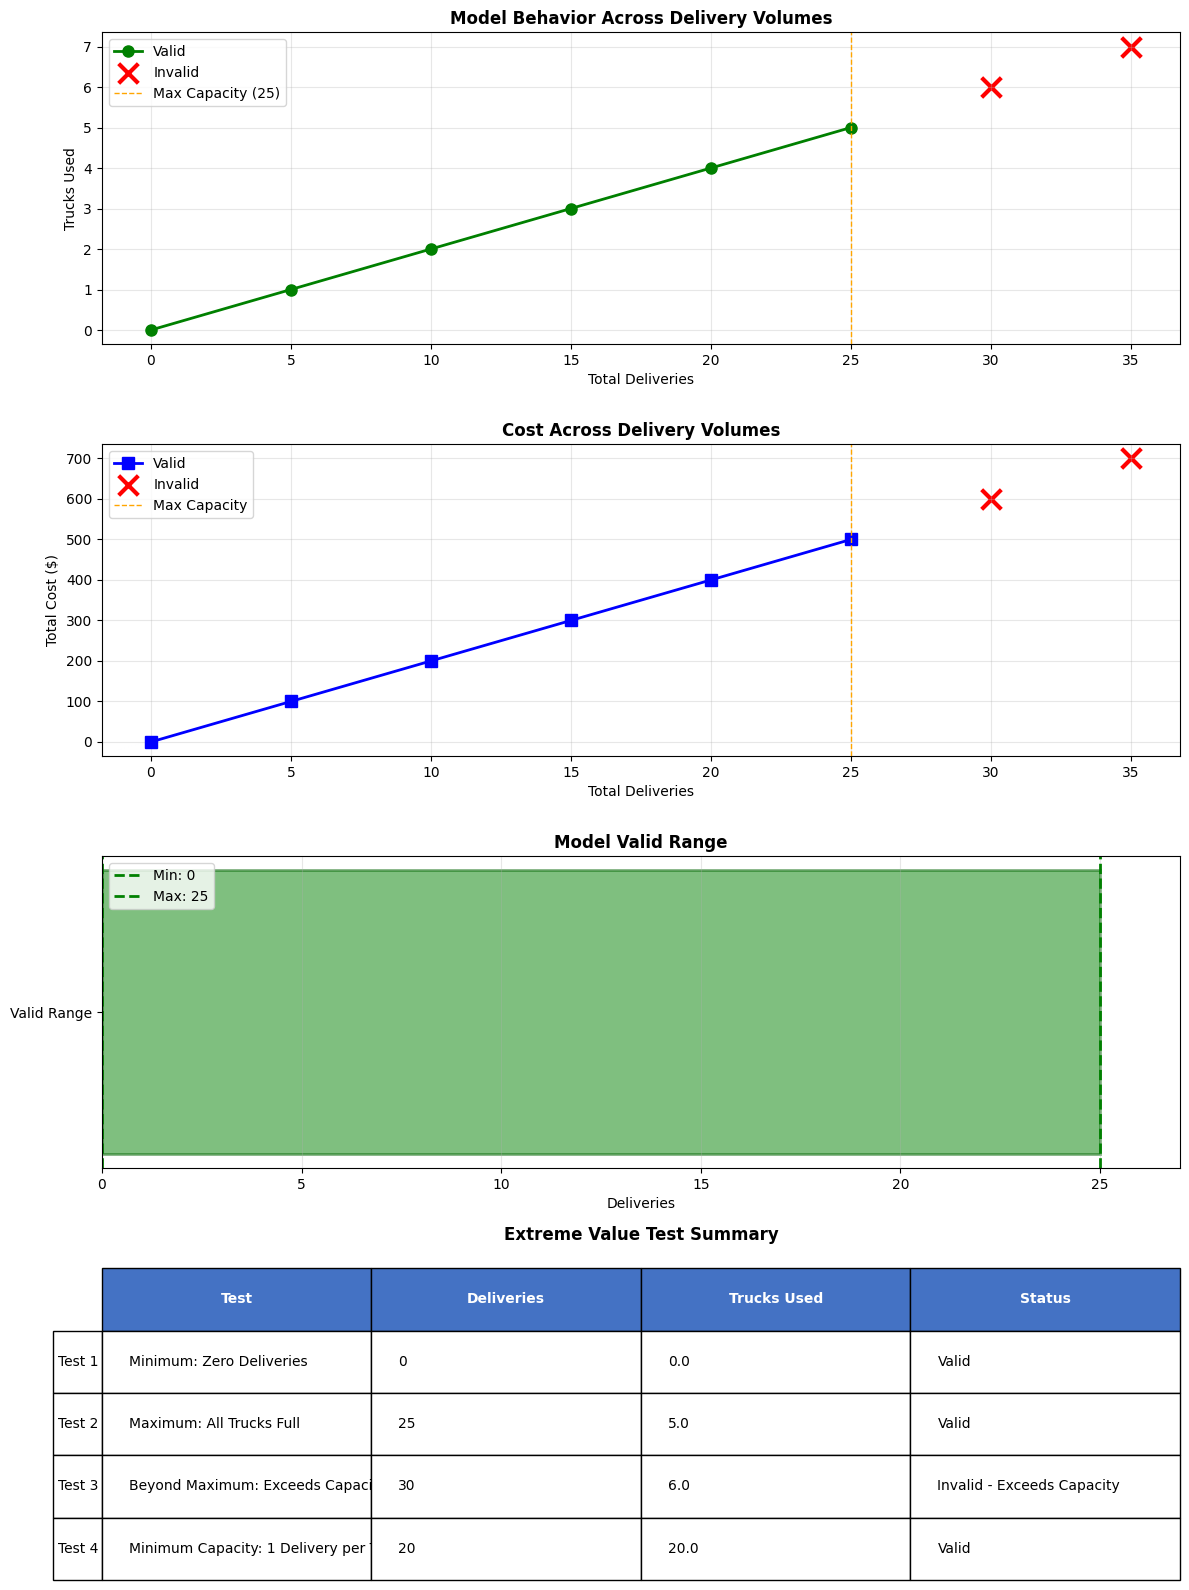

EXTREME VALUE TEST SUMMARY:


,Test,Deliveries,Trucks Used,Status
0,Minimum: Zero Deliveries,0,0.0,Valid
1,Maximum: All Trucks Full,25,5.0,Valid
2,Beyond Maximum: Exceeds Capacity,30,6.0,Invalid - Exceeds Capacity
3,Minimum Capacity: 1 Delivery per Truck,20,20.0,Valid


In [27]:
# Create comprehensive test results
extreme_results_df = pd.DataFrame(extreme_tests)

# Test a range of delivery values
delivery_range = [0, 5, 10, 15, 20, 25, 30, 35]
range_results = []

for deliveries in delivery_range:
    trucks, cost, status, valid = solve_delivery_model(deliveries, base_capacity)
    range_results.append({
        'Deliveries': deliveries,
        'Trucks Used': trucks,
        'Total Cost': cost,
        'Valid': valid,
        'Status': 'Valid' if valid else 'Invalid'
    })

range_df = pd.DataFrame(range_results)

# Visualize - one plot per row for better readability
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Plot 1: Trucks Used vs Deliveries
ax1 = axes[0]
valid_data = range_df[range_df['Valid']]
invalid_data = range_df[~range_df['Valid']]

ax1.plot(valid_data['Deliveries'], valid_data['Trucks Used'], 
         marker='o', linewidth=2, markersize=8, color='green', label='Valid')
if len(invalid_data) > 0:
    ax1.scatter(invalid_data['Deliveries'], invalid_data['Trucks Used'], 
               marker='x', s=200, color='red', label='Invalid', linewidths=3)
ax1.axvline(x=25, color='orange', linestyle='--', linewidth=1, label='Max Capacity (25)')
ax1.set_xlabel('Total Deliveries')
ax1.set_ylabel('Trucks Used')
ax1.set_title('Model Behavior Across Delivery Volumes', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Cost vs Deliveries
ax2 = axes[1]
ax2.plot(valid_data['Deliveries'], valid_data['Total Cost'], 
         marker='s', linewidth=2, markersize=8, color='blue', label='Valid')
if len(invalid_data) > 0:
    ax2.scatter(invalid_data['Deliveries'], invalid_data['Total Cost'], 
               marker='x', s=200, color='red', label='Invalid', linewidths=3)
ax2.axvline(x=25, color='orange', linestyle='--', linewidth=1, label='Max Capacity')
ax2.set_xlabel('Total Deliveries')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title('Cost Across Delivery Volumes', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Valid Range Visualization
ax3 = axes[2]
valid_range = range_df[range_df['Valid']]
if len(valid_range) > 0:
    min_valid = valid_range['Deliveries'].min()
    max_valid = valid_range['Deliveries'].max()
    # Set x-axis limits to show the valid range clearly with some padding
    x_min = max(0, min_valid - 2)
    x_max = max_valid + 2
    ax3.set_xlim(x_min, x_max)
    
    ax3.barh(['Valid Range'], [max_valid - min_valid], left=min_valid, 
            color='green', alpha=0.5, edgecolor='darkgreen', linewidth=2)
    ax3.axvline(x=min_valid, color='green', linestyle='--', linewidth=2, label=f'Min: {min_valid}')
    ax3.axvline(x=max_valid, color='green', linestyle='--', linewidth=2, label=f'Max: {max_valid}')
    ax3.set_xlabel('Deliveries')
    ax3.set_title('Model Valid Range', fontweight='bold')
    ax3.legend()
    ax3.grid(axis='x', alpha=0.3)

# Plot 4: Extreme Test Summary Table
ax4 = axes[3]
ax4.axis('off')
table_data = extreme_results_df[['Test', 'Deliveries', 'Trucks Used', 'Status']]
# Format the data for better display
table_values = []
for _, row in table_data.iterrows():
    table_values.append([
        row['Test'],
        f"{row['Deliveries']:.0f}",
        f"{row['Trucks Used']:.1f}",
        row['Status']
    ])

table = ax4.table(cellText=table_values,
                 rowLabels=[f"Test {i+1}" for i in range(len(table_values))],
                 colLabels=table_data.columns,
                 cellLoc='left',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
# Increase row height significantly to prevent overlapping
table.scale(1, 3.5)
# Style header row
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax4.set_title('Extreme Value Test Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("EXTREME VALUE TEST SUMMARY:")
print("=" * 80)
display(extreme_results_df[['Test', 'Deliveries', 'Trucks Used', 'Status']])


In [28]:
# Determine valid range
valid_range_data = range_df[range_df['Valid']]
if len(valid_range_data) > 0:
    min_valid_deliveries = valid_range_data['Deliveries'].min()
    max_valid_deliveries = valid_range_data['Deliveries'].max()
else:
    min_valid_deliveries = 0
    max_valid_deliveries = 0

model_limits = pd.DataFrame({
    'Limit Type': [
        'Minimum Deliveries',
        'Maximum Deliveries',
        'Minimum Capacity',
        'Maximum Capacity',
        'Valid Delivery Range'
    ],
    'Value': [
        f"{min_valid_deliveries} deliveries",
        f"{max_valid_deliveries} deliveries",
        f"{min_capacity} delivery per truck",
        f"{base_capacity * 5} deliveries (all trucks)",
        f"{min_valid_deliveries} - {max_valid_deliveries} deliveries"
    ],
    'Status': [
        'Valid' if min_valid_deliveries == 0 else 'Issue: Model fails at minimum',
        'Valid' if max_valid_deliveries >= 25 else 'Issue: Model fails before maximum',
        'Valid',
        'Valid',
        'Model reliable in this range'
    ]
})

print("MODEL LIMITS DOCUMENTATION:")
print("=" * 80)
display(model_limits)

print("\nRECOMMENDATIONS:")
print("  • Model is reliable for deliveries between {} and {} units".format(min_valid_deliveries, max_valid_deliveries))
print("  • For deliveries < {}: Use manual planning or alternative method".format(min_valid_deliveries))
print("  • For deliveries > {}: Model cannot handle - use alternative method".format(max_valid_deliveries))
print("  • Monitor delivery volumes and switch methods when approaching limits")


MODEL LIMITS DOCUMENTATION:


,Limit Type,Value,Status
0,Minimum Deliveries,0 deliveries,Valid
1,Maximum Deliveries,25 deliveries,Valid
2,Minimum Capacity,1 delivery per truck,Valid
3,Maximum Capacity,25 deliveries (all trucks),Valid
4,Valid Delivery Range,0 - 25 deliveries,Model reliable in this range



RECOMMENDATIONS:
  • Model is reliable for deliveries between 0 and 25 units
  • For deliveries < 0: Use manual planning or alternative method
  • For deliveries > 25: Model cannot handle - use alternative method
  • Monitor delivery volumes and switch methods when approaching limits


## Summary: Extreme-Value Testing

**What We Learned**:
- **Extreme-value testing** tests model behavior at boundaries (minimum and maximum values)
- **Models have limits** - they work well for normal conditions but may break at extremes
- **Extreme conditions happen** - even if rare, you need to be prepared
- **Testing extremes finds problems early** - before they cause damage during crises

**Key Insights**:
1. **Test minimum values**: See what happens when inputs are at their lowest
2. **Test maximum values**: See what happens when inputs are at their highest
3. **Test beyond maximum**: See if the model correctly identifies impossible situations
4. **Document limits**: Know when the model is reliable and when to use alternatives

**Practical Application**:
- Always perform extreme-value testing to find model limits
- Document the valid range where the model is reliable
- Prepare alternative methods for conditions outside the valid range
- Monitor conditions and switch methods when approaching limits
- Don't assume models work for all conditions - they have limits
